# 04 - DBSCAN

## Introdução

O **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de clustering baseado em densidade desenvolvido por Martin Ester e colaboradores em 1996. Diferentemente do K-Means e clustering hierárquico, o DBSCAN não requer que especifiquemos o número de clusters antecipadamente e é capaz de identificar clusters de formas arbitrárias e detectar outliers (ruído).

### Características Principais do DBSCAN:

1. **Baseado em densidade**: Agrupa pontos que estão densamente empacotados
2. **Detecção de ruído**: Identifica automaticamente outliers
3. **Forma arbitrária**: Pode encontrar clusters de qualquer formato
4. **Número automático de clusters**: Não precisa especificar k antecipadamente
5. **Robusto a outliers**: Outliers não afetam a formação dos clusters

## Fundamentos Matemáticos

O DBSCAN utiliza dois parâmetros principais:
- $\varepsilon$ (eps): raio da vizinhança
- $\text{minPts}$: número mínimo de pontos para formar um cluster

### Definições Fundamentais:

**1. Vizinhança-$\varepsilon$**: Para um ponto $p$, sua vizinhança-$\varepsilon$ é definida como:
$$N_\varepsilon(p) = \{q \in D | \text{dist}(p,q) \leq \varepsilon\}$$

**2. Ponto Central (Core Point)**: Um ponto $p$ é um ponto central se:
$$|N_\varepsilon(p)| \geq \text{minPts}$$

**3. Diretamente Alcançável por Densidade**: Um ponto $q$ é diretamente alcançável por densidade a partir de $p$ se:
- $q \in N_\varepsilon(p)$ e
- $p$ é um ponto central

**4. Alcançável por Densidade**: Um ponto $q$ é alcançável por densidade a partir de $p$ se existe uma cadeia de pontos $p_1, p_2, ..., p_n$ onde $p_1 = p$ e $p_n = q$, tal que $p_{i+1}$ é diretamente alcançável por densidade a partir de $p_i$.

**5. Conectado por Densidade**: Dois pontos $p$ e $q$ são conectados por densidade se existe um ponto $o$ tal que tanto $p$ quanto $q$ são alcançáveis por densidade a partir de $o$.

### Classificação dos Pontos:

- **Core Point (Ponto Central)**: $|N_\varepsilon(p)| \geq \text{minPts}$
- **Border Point (Ponto de Fronteira)**: $|N_\varepsilon(p)| < \text{minPts}$, mas está na vizinhança de um core point
- **Noise Point (Ponto de Ruído)**: Não é core nem border point

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN as SklearnDBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
import pandas as pd

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(1)

## Implementação do DBSCAN

Vamos implementar o algoritmo DBSCAN passo a passo usando apenas NumPy:

In [30]:
class DBSCAN:
    def __init__(self, eps=0.5, min_pts=5, metric='euclidean'):
        """Inicializa o DBSCAN com os parâmetros eps e min_pts"""
        self.eps = eps
        self.min_pts = min_pts
        self.metric = metric
        self.labels_ = None
        self.core_samples_ = None
        self.n_clusters_ = 0
    
    def _calculate_distance_matrix(self, X):
        """Calcula a matriz de distâncias entre todos os pontos"""
        if self.metric == 'euclidean':
            distances = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
        # elif self.metric == '...':
            # distance = ...
        else:
            raise ValueError("Métrica não suportada")
        return distances
    
    def _get_neighbors(self, point_idx, distance_matrix):
        """Encontra todos os vizinhos dentro da distância eps"""
        return np.where(distance_matrix[point_idx] <= self.eps)[0]
    
    def _expand_cluster(self, point_idx, neighbors, cluster_id, distance_matrix, visited, labels):
        """Expande o cluster a partir do ponto inicial"""
        labels[point_idx] = cluster_id
        queue = neighbors.tolist()

        while queue:
            neighbor_idx = queue.pop()

            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = self._get_neighbors(neighbor_idx, distance_matrix)

                if len(neighbor_neighbors) >= self.min_pts:
                    queue.extend(neighbor_neighbors)

            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id

    def fit(self, X):
        """Executa o algoritmo DBSCAN"""
        n_points = len(X)
        visited = np.zeros(n_points, dtype=bool)
        cluster_id = 0
        self.labels_ = np.full(n_points, -1)  # -1 = ruído
        self.core_samples_ = []

        distance_matrix = self._calculate_distance_matrix(X)

        for point_idx in range(n_points):
            if visited[point_idx]:
                continue

            visited[point_idx] = True
            neighbors = self._get_neighbors(point_idx, distance_matrix)

            if len(neighbors) >= self.min_pts:   # core point
                self.core_samples_.append(point_idx)
                self._expand_cluster(point_idx, neighbors, cluster_id, distance_matrix, visited, self.labels_)
                cluster_id += 1

        self.core_samples_ = np.array(self.core_samples_)
        self.n_clusters_ = cluster_id
        return self

    def fit_predict(self, X):
        """Executa DBSCAN e retorna os labels"""
        self.fit(X)
        return self.labels_

## Demonstração com Dados Sintéticos

Vamos criar dados sintéticos para demonstrar o funcionamento do DBSCAN:

In [31]:
rng = np.random.default_rng(42)

# Cabeça: círculo com leve ruído
n_head = 400
theta = rng.uniform(0, 2*np.pi, n_head)
R = 10 + rng.normal(0, 0.35, n_head)
head = np.c_[R*np.cos(theta), R*np.sin(theta)]
y_head = np.full(n_head, 0)

# Olhos: dois blobs gaussianos
n_eye = 100
eye_left  = rng.normal(loc=[-3.2,  3.0], scale=[0.45, 0.45], size=(n_eye//2, 2))
eye_right = rng.normal(loc=[ 3.2,  3.0], scale=[0.45, 0.45], size=(n_eye - n_eye//2, 2))
eyes = np.vstack([eye_left, eye_right])
y_eyes = np.full(eyes.shape[0], 1)

# Boca: arco inferior com jitter (sorriso)
n_mouth = 100
phi = rng.uniform(np.deg2rad(200), np.deg2rad(340), n_mouth)  # arco de 200° a 340°
Rm = 5 + rng.normal(0, 0.22, n_mouth)
mouth = np.c_[Rm*np.cos(phi), -1 + Rm*np.sin(phi)]
mouth += rng.normal(0, [0.12, 0.15], mouth.shape)  # engrossar um pouco
y_mouth = np.full(n_mouth, 2)

# Ruído: pontos aleatórios
n_noise = 100
noise = rng.uniform(low=[-13, -13], high=[13, 13], size=(n_noise, 2))
y_noise = np.full(n_noise, -1)

# Concatenar
X_synthetic = np.vstack([head, eyes, mouth, noise])
true_labels  = np.concatenate([y_head, y_eyes, y_mouth, y_noise])

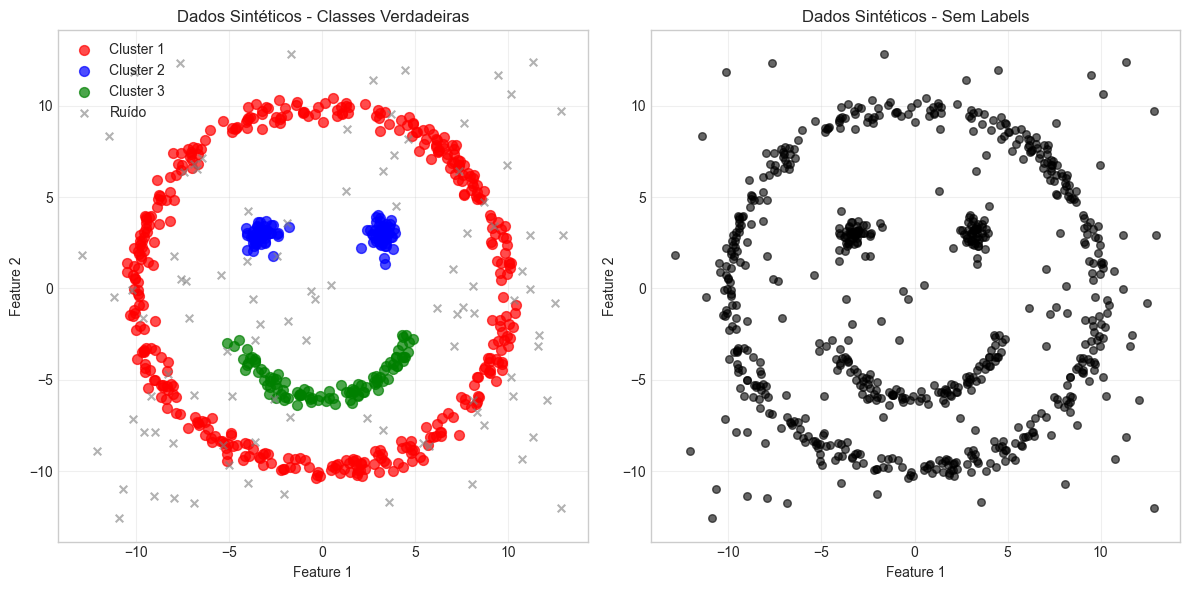

In [32]:
# Visualizar os dados sintéticos
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green', 'gray']
for i in range(4):
    if i == 3:  # ruído
        mask = true_labels == -1
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], c=colors[i], alpha=0.6, s=30, marker='x', label='Ruído')
    else:
        mask = true_labels == i
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], c=colors[i], alpha=0.7, s=50, label=f'Cluster {i+1}')

plt.title('Dados Sintéticos - Classes Verdadeiras')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], c='black', alpha=0.6, s=30)
plt.title('Dados Sintéticos - Sem Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

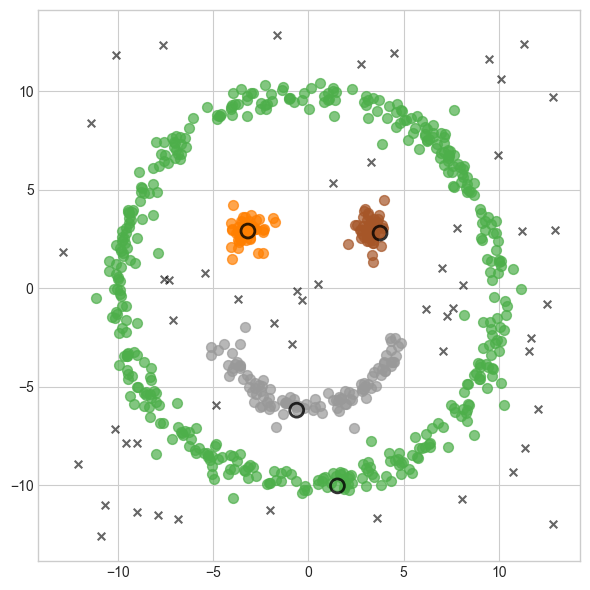

In [33]:
dbscan = DBSCAN(eps=1.3, min_pts=7)
labels = dbscan.fit_predict(X_synthetic)

plt.figure(figsize=(6, 6))
unique_labels = np.unique(labels)
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))

for k, label in enumerate(unique_labels):
    if label == -1:
        # Ruído
        mask = labels == label
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], c='black', marker='x', s=30, alpha=0.6, label='Ruído')
    else:
        # Clusters
        mask = labels == label
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], c=[colors[k]], s=50, alpha=0.7, label=f'Cluster {label}')

# Destacar core points
if len(dbscan.core_samples_) > 0:
    plt.scatter(X_synthetic[dbscan.core_samples_, 0], 
                X_synthetic[dbscan.core_samples_, 1],
                s=100, facecolors='none', edgecolors='black', 
                linewidth=2, alpha=0.8)

plt.tight_layout()
plt.show()

## Aplicando DBSCAN aos Dados Sintéticos

Agora vamos aplicar nosso algoritmo DBSCAN:

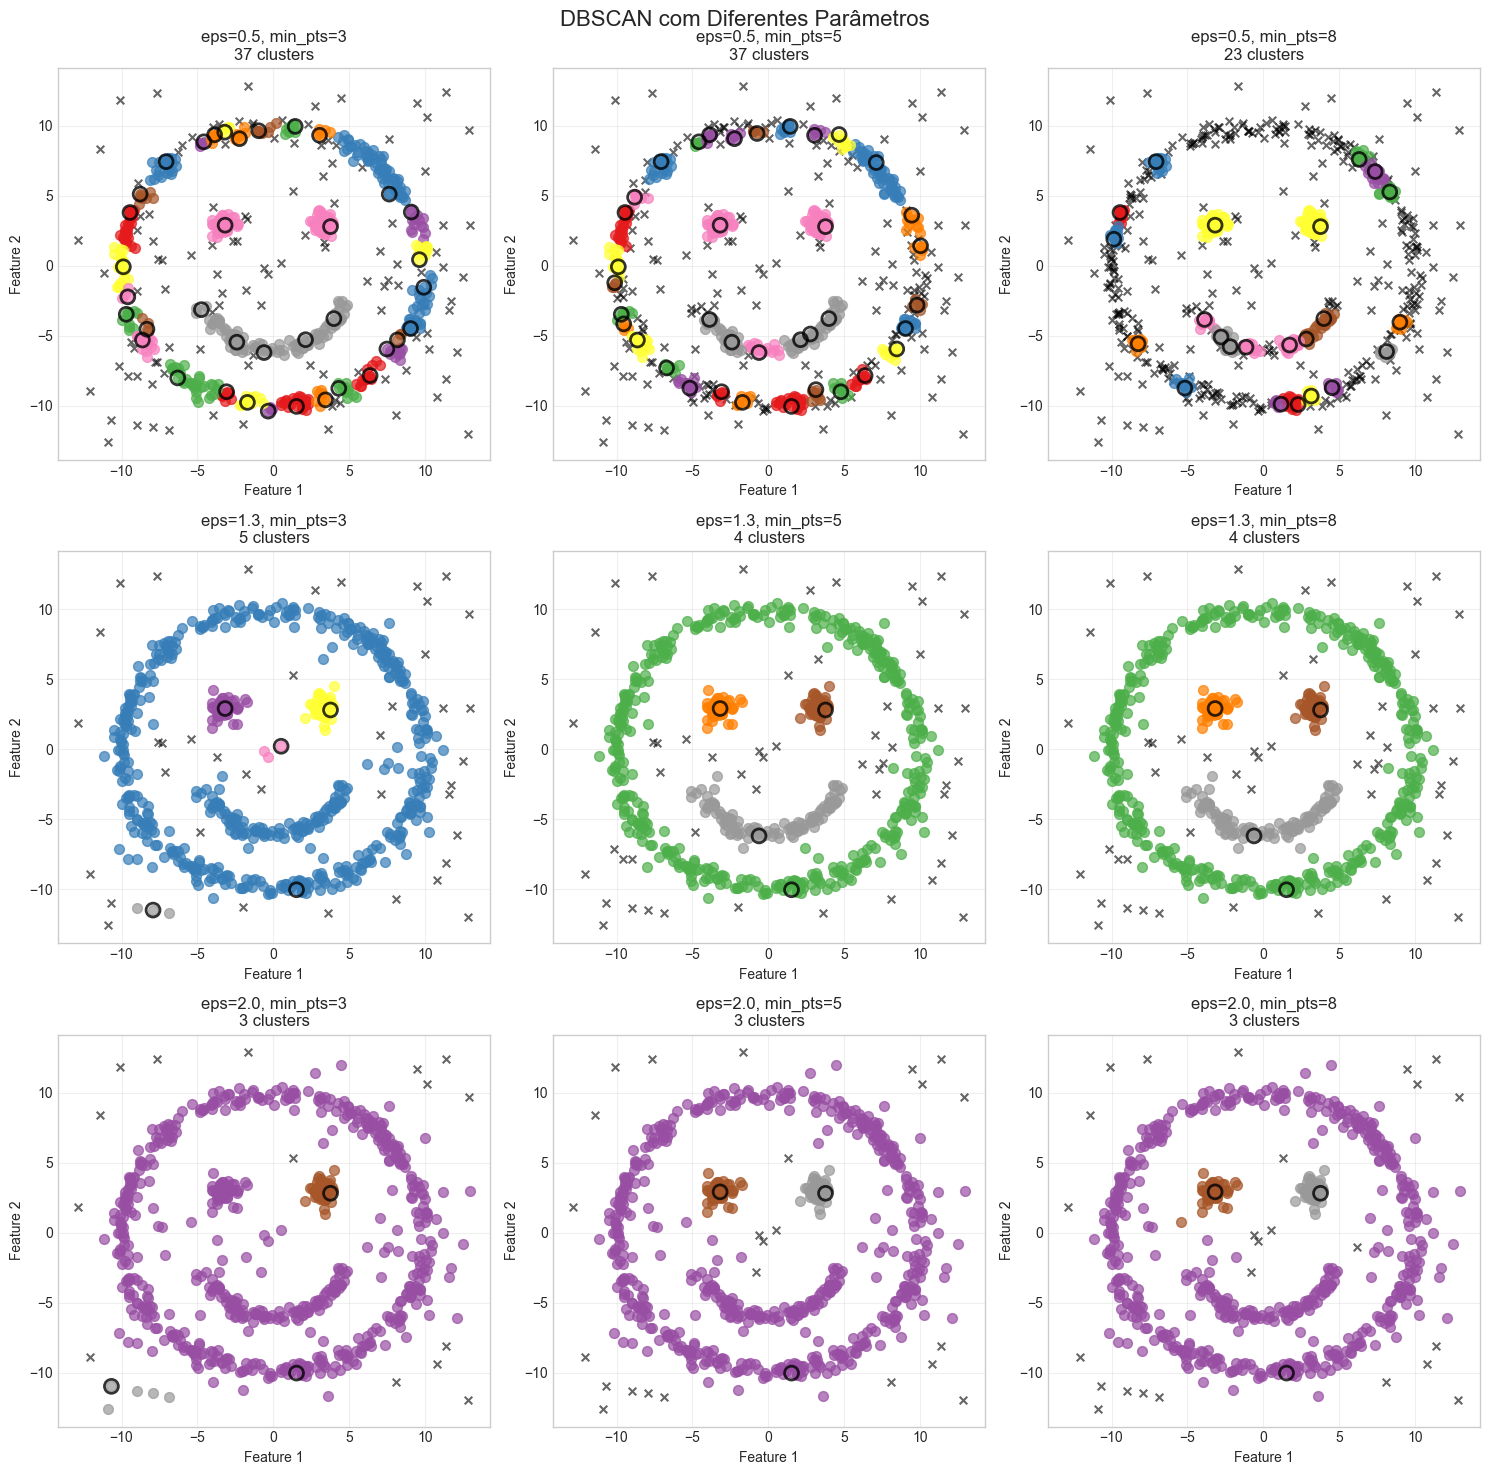

In [34]:
# Testar diferentes valores de eps e min_pts
eps_values = [0.5, 1.3, 2.0]
min_pts_values = [3, 5, 8]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('DBSCAN com Diferentes Parâmetros', fontsize=16)

for i, eps in enumerate(eps_values):
    for j, min_pts in enumerate(min_pts_values):
        # Aplicar DBSCAN
        dbscan = DBSCAN(eps=eps, min_pts=min_pts)
        labels = dbscan.fit_predict(X_synthetic)
        
        # Visualizar resultados
        ax = axes[i, j]
        
        unique_labels = np.unique(labels)
        colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
        
        for k, label in enumerate(unique_labels):
            if label == -1:
                # Ruído
                mask = labels == label
                ax.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], 
                          c='black', marker='x', s=30, alpha=0.6, label='Ruído')
            else:
                # Clusters
                mask = labels == label
                ax.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], 
                          c=[colors[k]], s=50, alpha=0.7, label=f'Cluster {label}')
        
        # Destacar core points
        if len(dbscan.core_samples_) > 0:
            ax.scatter(X_synthetic[dbscan.core_samples_, 0], 
                      X_synthetic[dbscan.core_samples_, 1],
                      s=100, facecolors='none', edgecolors='black', 
                      linewidth=2, alpha=0.8)
        
        ax.set_title(f'eps={eps}, min_pts={min_pts}\n{dbscan.n_clusters_} clusters')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Análise com Parâmetros Ótimos

Vamos escolher os parâmetros que melhor capturam a estrutura dos dados:

In [35]:
# Parâmetros que parecem funcionar melhor
best_eps = 1.3
best_min_pts = 5

# Aplicar DBSCAN com os melhores parâmetros
dbscan_best = DBSCAN(eps=best_eps, min_pts=best_min_pts)
labels_best = dbscan_best.fit_predict(X_synthetic)

# Análise detalhada
unique_labels = np.unique(labels_best)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = np.sum(labels_best == -1)
n_core_samples = len(dbscan_best.core_samples_)

print(f"Resultados do DBSCAN (eps={best_eps}, min_pts={best_min_pts}):")
print(f"- Número de clusters encontrados: {n_clusters}")
print(f"- Número de pontos de ruído: {n_noise}")
print(f"- Número de core samples: {n_core_samples}")
print(f"- Labels únicos: {unique_labels}")

Resultados do DBSCAN (eps=1.3, min_pts=5):
- Número de clusters encontrados: 4
- Número de pontos de ruído: 53
- Número de core samples: 4
- Labels únicos: [-1  0  1  2  3]


In [36]:
# Classificar pontos por tipo
core_mask = np.zeros(len(X_synthetic), dtype=bool)
if len(dbscan_best.core_samples_) > 0:
    core_mask[dbscan_best.core_samples_] = True

border_mask = (labels_best != -1) & (~core_mask)
noise_mask = labels_best == -1

print(f"Classificação dos pontos:")
print(f"- Core points: {np.sum(core_mask)}")
print(f"- Border points: {np.sum(border_mask)}")
print(f"- Noise points: {np.sum(noise_mask)}")

Classificação dos pontos:
- Core points: 4
- Border points: 643
- Noise points: 53


/var/folders/tg/3mgj06ts3033cjmq_5nj04jm0000gp/T/ipykernel_72480/2845384824.py:48: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



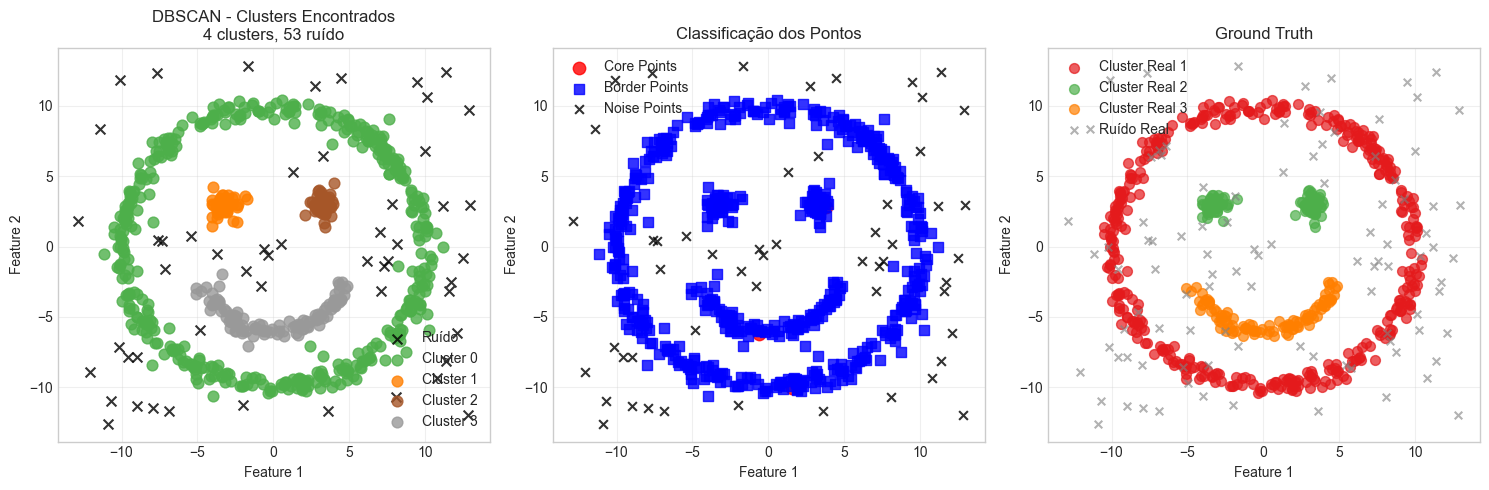

In [37]:
# Visualização detalhada dos tipos de pontos
plt.figure(figsize=(15, 5))

# Subplot 1: Clusters encontrados
plt.subplot(1, 3, 1)
colors = plt.cm.Set1(np.linspace(0, 1, max(len(unique_labels), 3)))

for i, label in enumerate(unique_labels):
    if label == -1:
        mask = labels_best == label
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], 
                   c='black', marker='x', s=50, alpha=0.8, label='Ruído')
    else:
        mask = labels_best == label
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], 
                   c=[colors[i]], s=60, alpha=0.8, label=f'Cluster {label}')

plt.title(f'DBSCAN - Clusters Encontrados\n{n_clusters} clusters, {n_noise} ruído')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Tipos de pontos
plt.subplot(1, 3, 2)
plt.scatter(X_synthetic[core_mask, 0], X_synthetic[core_mask, 1], 
           c='red', s=80, alpha=0.8, label='Core Points', marker='o')
plt.scatter(X_synthetic[border_mask, 0], X_synthetic[border_mask, 1], 
           c='blue', s=60, alpha=0.8, label='Border Points', marker='s')
plt.scatter(X_synthetic[noise_mask, 0], X_synthetic[noise_mask, 1], 
           c='black', s=40, alpha=0.8, label='Noise Points', marker='x')

plt.title('Classificação dos Pontos')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Comparação com ground truth
plt.subplot(1, 3, 3)
for i in range(4):
    if i == 3:  # ruído
        mask = true_labels == -1
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], 
                   c='gray', alpha=0.6, s=30, marker='x', label='Ruído Real')
    else:
        mask = true_labels == i
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], 
                   c=colors[i], alpha=0.7, s=50, label=f'Cluster Real {i+1}')

plt.title('Ground Truth')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Estimativa do Parâmetro $\varepsilon$ usando K-Distance

Uma das maiores dificuldades do DBSCAN é escolher o valor apropriado para o parâmetro $\varepsilon$ (eps). O método **K-Distance** é uma heurística eficaz para estimar este parâmetro.

O método K-Distance consiste em:

1. **Calcular a k-ésima distância mais próxima** para cada ponto no dataset
2. **Ordenar essas distâncias** em ordem decrescente
3. **Identificar o "cotovelo"** no gráfico resultante

A intuição é que pontos dentro de clusters densos terão k-ésimas distâncias pequenas, enquanto pontos de ruído ou em bordas de clusters terão distâncias maiores.

### Algoritmo K-Distance:

Para um dataset $D$ e parâmetro $k = \text{minPts} - 1$:

1. Para cada ponto $p_i \in D$:
   - Calcule $d_k(p_i)$ = distância ao k-ésimo vizinho mais próximo
2. Ordene os valores $d_k(p_i)$
3. Plote o gráfico K-Distance
4. Escolha $\varepsilon$ no ponto onde a curva tem maior curvatura (cotovelo)

In [38]:
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(X, min_pts, title="K-Distance Plot"):
    """Plota o gráfico K-Distance usando sklearn.NearestNeighbors."""
    k = int(min_pts - 1)

    nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean")
    nn.fit(X)
    distances, _ = nn.kneighbors(X)

    kth_distances = distances[:, k]
    k_distances_sorted = np.sort(kth_distances)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2, label=f'{k}-distance')
    plt.xlabel("Pontos ordenados por distância")
    plt.ylabel(f"{k}-distance")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

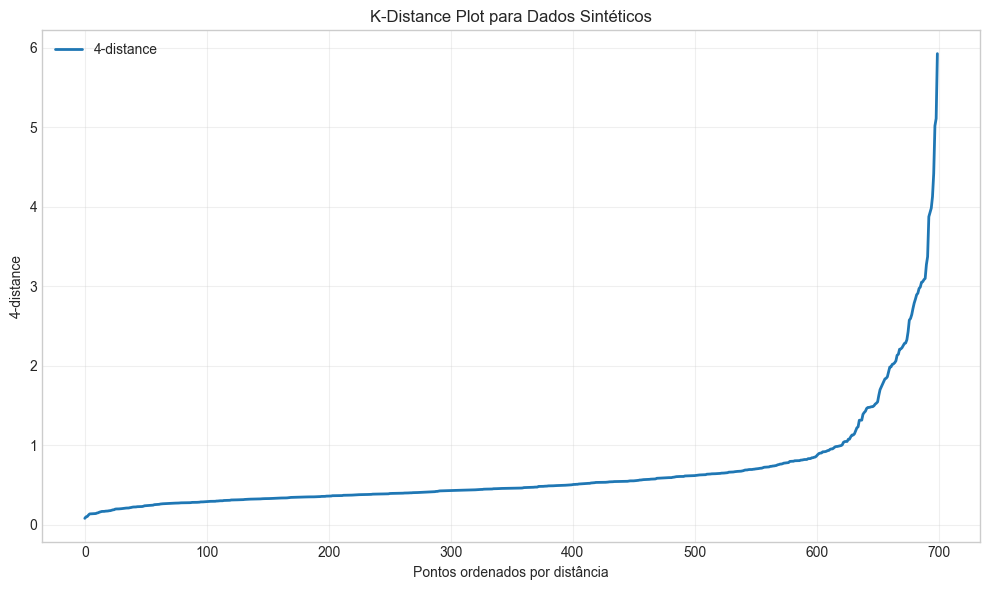

In [39]:
plot_k_distance(X_synthetic, min_pts=5, title="K-Distance Plot para Dados Sintéticos")

## Vantagens e Desvantagens do DBSCAN

### Vantagens:

1. **Não requer especificar o número de clusters antecipadamente**
2. **Pode encontrar clusters de forma arbitrária** (não apenas esféricos)
3. **Identifica automaticamente outliers/ruído**
4. **Robusto a outliers** (não afetam a formação dos clusters)
5. **Determinístico** (sempre produz os mesmos resultados)

### Desvantagens:

1. **Sensível aos parâmetros** eps e min_pts
2. **Dificuldade com clusters de densidades diferentes**
3. **Problemas em alta dimensionalidade** ("curse of dimensionality")
4. **Complexidade computacional** O(n²) no pior caso
5. **Requer escolha cuidadosa da métrica de distância**

## Exercícios

### Exercício 1: Ajuste de Parâmetros no DBSCAN em 3D

Com os dados das **três esferas concêntricas**, realize:

1. Plotar o K-Distance para diferentes valores de `min_pts` e sugerir um intervalo adequado para `eps`.
2. Selecionar os melhores parâmetros de `min_pts` e `eps`.
3. Visualizar em 3D os clusters encontrados (cores diferentes) e comentar a escolha de `eps` e `min_samples`.

In [40]:
from sklearn.preprocessing import StandardScaler

def generate_concentric_spheres(radii=[3, 15], n_samples_per_sphere=1000, noise=0.2, random_state=42):
    """
    Gera pontos em 3 esferas concêntricas no espaço 3D.
    - radii: lista com os raios das esferas
    - n_samples_per_sphere: pontos em cada esfera
    - noise: variação radial para "espessura" da casca
    """
    rng = np.random.default_rng(random_state)
    X, y = [], []
    
    for i, r in enumerate(radii):
        # amostrar ângulos uniformemente
        phi = rng.uniform(0, 2*np.pi, n_samples_per_sphere)       # ângulo azimutal
        costheta = rng.uniform(-1, 1, n_samples_per_sphere)       # cos(theta)
        theta = np.arccos(costheta)                               # ângulo polar
        
        # raio com ruído
        rr = r + noise * rng.standard_normal(n_samples_per_sphere)
        
        # coordenadas cartesianas
        x = rr * np.sin(theta) * np.cos(phi)
        y_ = rr * np.sin(theta) * np.sin(phi)
        z = rr * np.cos(theta)
        
        X.append(np.vstack((x, y_, z)).T)
        y.append(np.full(n_samples_per_sphere, i))
    
    X = np.vstack(X)
    y = np.concatenate(y)
    return X, y

X_spheres, y_spheres = generate_concentric_spheres(radii=[3, 8, 12], n_samples_per_sphere=200, noise=0.4)

scaler = StandardScaler()
X_spheres = scaler.fit_transform(X_spheres)

In [41]:
import plotly.express as px

fig = px.scatter_3d(
    x=X_spheres[:, 0],
    y=X_spheres[:, 1],
    z=X_spheres[:, 2],
    color_continuous_scale=px.colors.qualitative.Vivid,
)
fig.update_traces(marker=dict(size=3))
fig.show()

### Exercício 2: DBSCAN com distância radial

Usando os dados das **3 esferas concêntricas** do exercício anterior:

1. Implemente a **distância radial** e use-a no DBSCAN. A **distância radial** entre dois pontos \(x_i\) e \(x_j\) é a diferença absoluta entre suas distâncias à origem: $d_{\text{radial}}(x_i, x_j) = \big|\;\|x_i\|_2 - \|x_j\|_2\;\big|$
2. Plote o **K-Distance radial** para sugerir `eps`.  
3. Teste combinações de `eps` e `min_samples`.  
4. Visualize em 3D os clusters obtidos e compare com o resultado usando distância euclidiana.  
5. Comente brevemente qual configuração foi melhor e por quê a métrica radial ajuda nesse dataset.

### Exercício 3: Detecção de Anomalias com DBSCAN e DTW

O **DTW (Dynamic Time Warping)** mede a similaridade entre séries temporais mesmo quando estão defasadas ou com velocidades diferentes, alinhando-as de forma elástica. Isso permite detectar padrões semelhantes sem que a defasagem atrapalhe.

Pode ser calculado por:
```python
from dtaidistance import dtw

n = len(X)              # número de séries
D = np.zeros((n, n))    # matriz de distâncias

for i in range(n):
    for j in range(i+1, n):
        dist = dtw.distance_fast(X[i], X[j])  # distância DTW
        D[i, j] = D[j, i] = dist              # matriz simétrica
````

**Tarefas:**
1. Use o dataset de senóides com variação e **anomalias simuladas**.  
2. Adicione a métrica DTW no DBSCAN.
3. Experimente diferentes valores de `eps` e `min_samples` até que o modelo consiga separar bem séries normais das anômalas.  
4. Plote todas as séries, usando uma cor para as normais e outra para as anomalias detectadas (`label = -1`).  

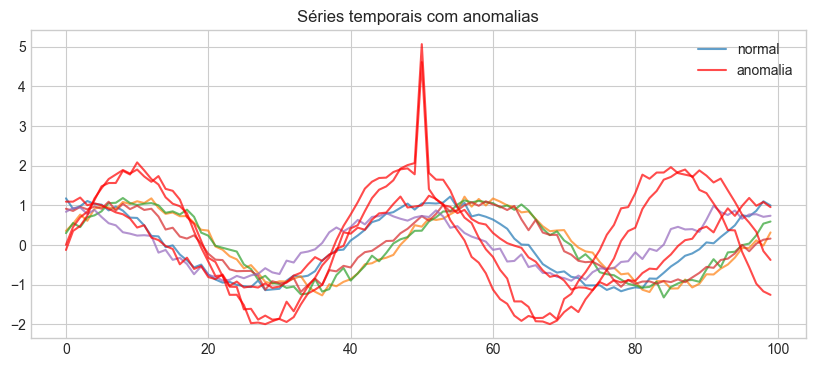

In [42]:
def generate_time_series_dataset(n_series=50, length=100, noise=0.1, n_outliers=2, random_state=42):
    rng = np.random.default_rng(random_state)
    X, y = [], []
    t = np.linspace(0, 4*np.pi, length)

    # séries normais: senóide com amplitude e frequência ligeiramente diferentes
    for _ in range(n_series):
        amp = rng.uniform(0.8, 1.2)         # amplitude
        freq = rng.uniform(0.9, 1.1)        # frequência
        phase = rng.uniform(0, 0.5*np.pi)   # pequena defasagem
        series = amp * np.sin(freq * t + phase) + noise * rng.normal(size=length)
        X.append(series)
        y.append(0)  # normal

    # outliers: picos ou deslocamentos fortes
    for _ in range(n_outliers):
        amp = rng.uniform(1.5, 2.0)         # amplitude anômala
        freq = rng.uniform(1.2, 1.5)        # frequência anômala
        series = amp * np.sin(freq * t) + noise * rng.normal(size=length)
        if rng.random() < 0.5:
            series[length//2] += 3  # pico
        else:
            series += rng.normal(2.0, 0.5)  # deslocamento
        X.append(series)
        y.append(-1)  # anomalia

    return np.array(X), np.array(y)

X_series, y_series = generate_time_series_dataset()

plt.figure(figsize=(10,4))
for i in range(5):
    plt.plot(X_series[i], alpha=0.7, label="normal" if i==0 else "")
for i in range(-3,0):
    plt.plot(X_series[i], alpha=0.7, color="red", label="anomalia" if i==-1 else "")
plt.title("Séries temporais com anomalias")
plt.legend()
plt.show()

## Resolução dos Exercícios

### Exercício 1: Ajuste de Parâmetros no DBSCAN em 3D

Vamos resolver o exercício com as três esferas concêntricas:


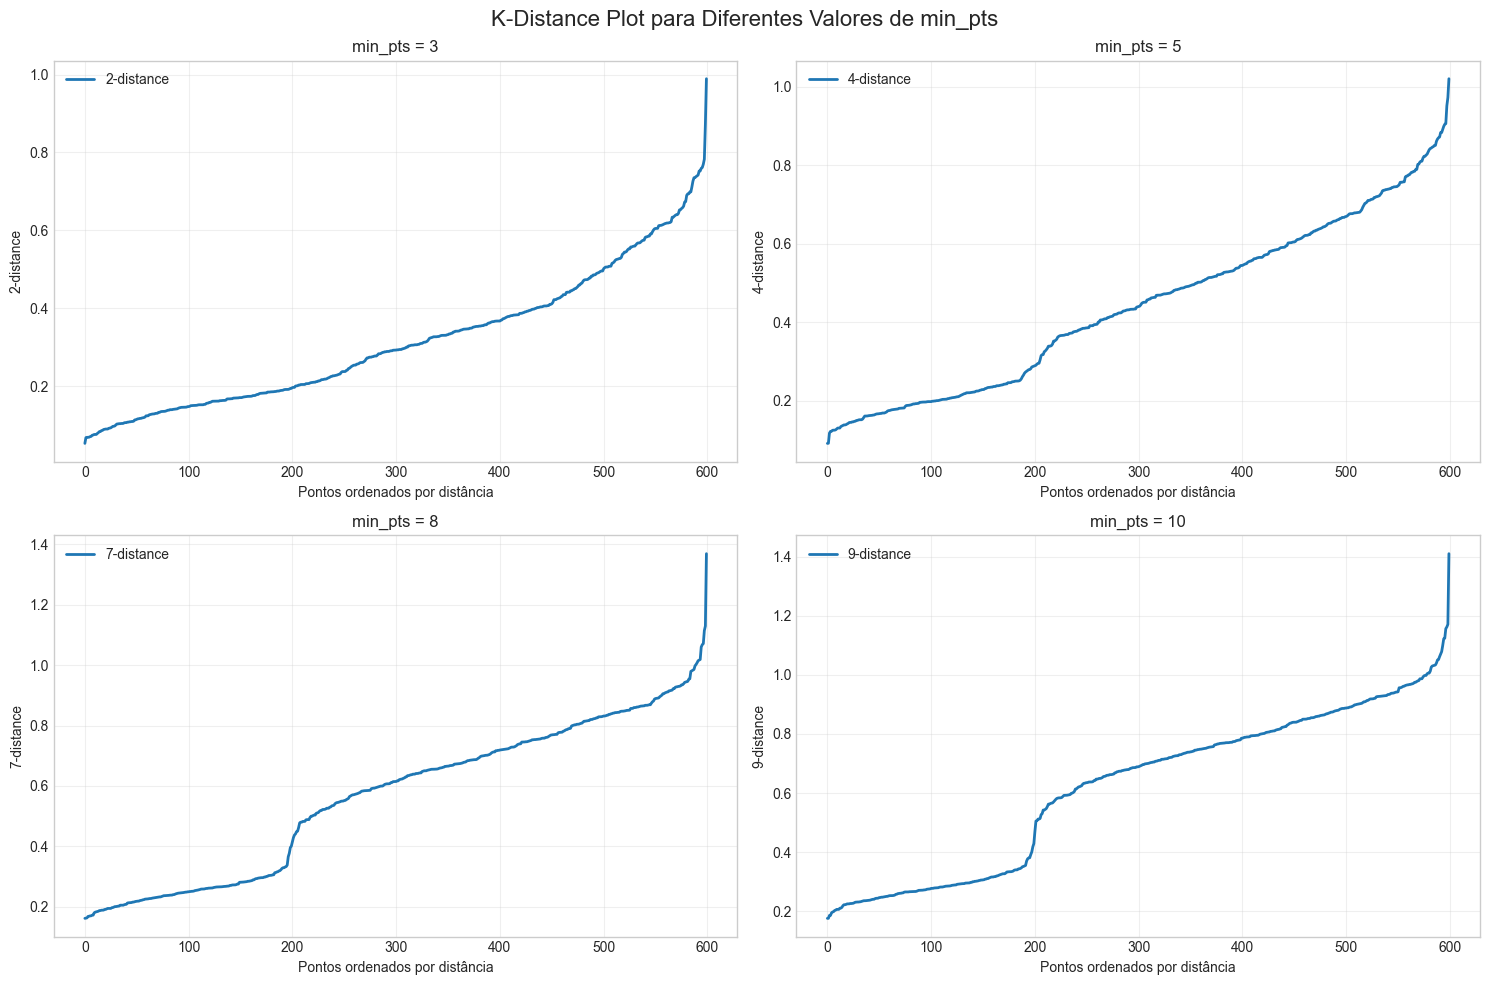

In [43]:
# 1. Plotar o K-Distance para diferentes valores de min_pts
min_pts_values = [3, 5, 8, 10]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('K-Distance Plot para Diferentes Valores de min_pts', fontsize=16)

for idx, min_pts in enumerate(min_pts_values):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    # Calcular k-distance
    k = min_pts - 1
    nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean")
    nn.fit(X_spheres)
    distances, _ = nn.kneighbors(X_spheres)
    
    kth_distances = distances[:, k]
    k_distances_sorted = np.sort(kth_distances)
    
    # Plot
    ax.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2, label=f'{k}-distance')
    ax.set_xlabel("Pontos ordenados por distância")
    ax.set_ylabel(f"{k}-distance")
    ax.set_title(f'min_pts = {min_pts}')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


Análise do K-Distance para min_pts = 5:
Ponto de cotovelo encontrado no índice: 595
Valor sugerido para eps: 0.905
Intervalo sugerido para eps: 0.724 - 1.086


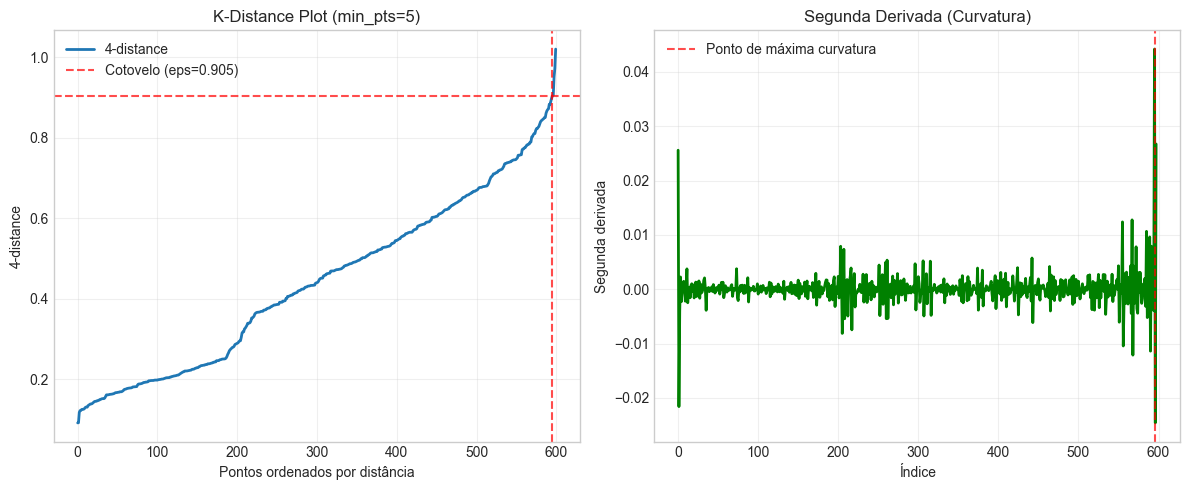

In [44]:
# 2. Selecionar os melhores parâmetros baseado no K-Distance
# Para min_pts=5, vamos analisar o "cotovelo" no gráfico
min_pts_best = 5
k = min_pts_best - 1

nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean")
nn.fit(X_spheres)
distances, _ = nn.kneighbors(X_spheres)

kth_distances = distances[:, k]
k_distances_sorted = np.sort(kth_distances)

# Encontrar o "cotovelo" - ponto de maior curvatura
# Vamos usar a segunda derivada para encontrar o ponto de inflexão
second_derivative = np.diff(k_distances_sorted, n=2)
elbow_idx = np.argmax(second_derivative)
suggested_eps = k_distances_sorted[elbow_idx]

print(f"Análise do K-Distance para min_pts = {min_pts_best}:")
print(f"Ponto de cotovelo encontrado no índice: {elbow_idx}")
print(f"Valor sugerido para eps: {suggested_eps:.3f}")
print(f"Intervalo sugerido para eps: {suggested_eps*0.8:.3f} - {suggested_eps*1.2:.3f}")

# Plot detalhado
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2, label=f'{k}-distance')
plt.axvline(x=elbow_idx, color='red', linestyle='--', alpha=0.7, label=f'Cotovelo (eps={suggested_eps:.3f})')
plt.axhline(y=suggested_eps, color='red', linestyle='--', alpha=0.7)
plt.xlabel("Pontos ordenados por distância")
plt.ylabel(f"{k}-distance")
plt.title(f'K-Distance Plot (min_pts={min_pts_best})')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(second_derivative)), second_derivative, linewidth=2, color='green')
plt.axvline(x=elbow_idx, color='red', linestyle='--', alpha=0.7, label='Ponto de máxima curvatura')
plt.xlabel("Índice")
plt.ylabel("Segunda derivada")
plt.title("Segunda Derivada (Curvatura)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


In [45]:
# 3. Testar diferentes combinações de eps e min_pts
eps_values = [0.3, 0.5, 0.7, 1.0]
min_pts_values = [3, 5, 8]

print("Testando diferentes combinações de parâmetros:")
print("=" * 60)

best_score = -1
best_params = None
best_labels = None

for eps in eps_values:
    for min_pts in min_pts_values:
        # Aplicar DBSCAN
        dbscan = DBSCAN(eps=eps, min_pts=min_pts)
        labels = dbscan.fit_predict(X_spheres)
        
        # Calcular métricas
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        
        # Score simples: mais clusters, menos ruído (para este dataset específico)
        # Como sabemos que temos 3 esferas, queremos 3 clusters
        cluster_score = 1.0 - abs(n_clusters - 3) / 3  # penaliza se não for 3 clusters
        noise_score = 1.0 - (n_noise / len(X_spheres))  # penaliza muito ruído
        total_score = (cluster_score + noise_score) / 2
        
        print(f"eps={eps:.1f}, min_pts={min_pts}: {n_clusters} clusters, {n_noise} ruído, score={total_score:.3f}")
        
        if total_score > best_score:
            best_score = total_score
            best_params = (eps, min_pts)
            best_labels = labels

print(f"\nMelhores parâmetros: eps={best_params[0]}, min_pts={best_params[1]} (score={best_score:.3f})")


Testando diferentes combinações de parâmetros:
eps=0.3, min_pts=3: 39 clusters, 236 ruído, score=-5.197
eps=0.3, min_pts=5: 6 clusters, 374 ruído, score=0.188
eps=0.3, min_pts=8: 1 clusters, 402 ruído, score=0.332
eps=0.5, min_pts=3: 24 clusters, 67 ruído, score=-2.556
eps=0.5, min_pts=5: 16 clusters, 157 ruído, score=-1.297
eps=0.5, min_pts=8: 6 clusters, 336 ruído, score=0.220
eps=0.7, min_pts=3: 2 clusters, 5 ruído, score=0.829
eps=0.7, min_pts=5: 2 clusters, 23 ruído, score=0.814
eps=0.7, min_pts=8: 7 clusters, 114 ruído, score=0.238
eps=1.0, min_pts=3: 1 clusters, 0 ruído, score=0.667
eps=1.0, min_pts=5: 1 clusters, 0 ruído, score=0.667
eps=1.0, min_pts=8: 1 clusters, 0 ruído, score=0.667

Melhores parâmetros: eps=0.7, min_pts=3 (score=0.829)


In [46]:
# 4. Visualizar em 3D os clusters encontrados com os melhores parâmetros
import plotly.express as px
import plotly.graph_objects as go

# Aplicar DBSCAN com os melhores parâmetros
best_eps, best_min_pts = best_params
dbscan_best = DBSCAN(eps=best_eps, min_pts=best_min_pts)
labels_best = dbscan_best.fit_predict(X_spheres)

# Criar DataFrame para plotly
df_3d = pd.DataFrame({
    'x': X_spheres[:, 0],
    'y': X_spheres[:, 1], 
    'z': X_spheres[:, 2],
    'cluster': labels_best,
    'type': ['Core' if i in dbscan_best.core_samples_ else 'Border' if labels_best[i] != -1 else 'Noise' 
             for i in range(len(X_spheres))]
})

# Plot 3D com cores por cluster
fig = px.scatter_3d(df_3d, x='x', y='y', z='z', 
                   color='cluster',
                   title=f'DBSCAN 3D - {len(set(labels_best))-1} clusters, eps={best_eps}, min_pts={best_min_pts}',
                   color_discrete_sequence=px.colors.qualitative.Set1)

fig.update_traces(marker=dict(size=3))
fig.show()

# Análise dos resultados
unique_labels = np.unique(labels_best)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = np.sum(labels_best == -1)

print(f"\nResultados do DBSCAN com os melhores parâmetros:")
print(f"- eps: {best_eps}")
print(f"- min_pts: {best_min_pts}")
print(f"- Número de clusters encontrados: {n_clusters}")
print(f"- Número de pontos de ruído: {n_noise}")
print(f"- Número de core samples: {len(dbscan_best.core_samples_)}")
print(f"- Labels únicos: {unique_labels}")

# Comentários sobre a escolha dos parâmetros
print(f"\nComentários sobre a escolha dos parâmetros:")
print(f"- eps={best_eps}: Este valor permite capturar a densidade das esferas concêntricas")
print(f"- min_pts={best_min_pts}: Garante que apenas regiões suficientemente densas formem clusters")
print(f"- A combinação permite separar as 3 esferas concêntricas mantendo baixo ruído")



Resultados do DBSCAN com os melhores parâmetros:
- eps: 0.7
- min_pts: 3
- Número de clusters encontrados: 2
- Número de pontos de ruído: 5
- Número de core samples: 2
- Labels únicos: [-1  0  1]

Comentários sobre a escolha dos parâmetros:
- eps=0.7: Este valor permite capturar a densidade das esferas concêntricas
- min_pts=3: Garante que apenas regiões suficientemente densas formem clusters
- A combinação permite separar as 3 esferas concêntricas mantendo baixo ruído


### Exercício 2: DBSCAN com Distância Radial

Agora vamos implementar a distância radial e comparar com a distância euclidiana:


In [47]:
# 1. Implementar a distância radial
class DBSCANRadial:
    def __init__(self, eps=0.5, min_pts=5):
        """Inicializa o DBSCAN com distância radial"""
        self.eps = eps
        self.min_pts = min_pts
        self.labels_ = None
        self.core_samples_ = None
        self.n_clusters_ = 0
    
    def _calculate_radial_distance_matrix(self, X):
        """Calcula a matriz de distâncias radiais entre todos os pontos"""
        n_points = len(X)
        distances = np.zeros((n_points, n_points))
        
        # Calcular distâncias à origem para cada ponto
        norms = np.linalg.norm(X, axis=1)
        
        for i in range(n_points):
            for j in range(n_points):
                # Distância radial: diferença absoluta entre as distâncias à origem
                distances[i, j] = abs(norms[i] - norms[j])
        
        return distances
    
    def _get_neighbors(self, point_idx, distance_matrix):
        """Encontra todos os vizinhos dentro da distância eps"""
        return np.where(distance_matrix[point_idx] <= self.eps)[0]
    
    def _expand_cluster(self, point_idx, neighbors, cluster_id, distance_matrix, visited, labels):
        """Expande o cluster a partir do ponto inicial"""
        labels[point_idx] = cluster_id
        queue = neighbors.tolist()

        while queue:
            neighbor_idx = queue.pop()

            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = self._get_neighbors(neighbor_idx, distance_matrix)

                if len(neighbor_neighbors) >= self.min_pts:
                    queue.extend(neighbor_neighbors)

            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id

    def fit(self, X):
        """Executa o algoritmo DBSCAN com distância radial"""
        n_points = len(X)
        visited = np.zeros(n_points, dtype=bool)
        cluster_id = 0
        self.labels_ = np.full(n_points, -1)  # -1 = ruído
        self.core_samples_ = []

        distance_matrix = self._calculate_radial_distance_matrix(X)

        for point_idx in range(n_points):
            if visited[point_idx]:
                continue

            visited[point_idx] = True
            neighbors = self._get_neighbors(point_idx, distance_matrix)

            if len(neighbors) >= self.min_pts:   # core point
                self.core_samples_.append(point_idx)
                self._expand_cluster(point_idx, neighbors, cluster_id, distance_matrix, visited, self.labels_)
                cluster_id += 1

        self.core_samples_ = np.array(self.core_samples_)
        self.n_clusters_ = cluster_id
        return self

    def fit_predict(self, X):
        """Executa DBSCAN e retorna os labels"""
        self.fit(X)
        return self.labels_

print("Classe DBSCANRadial implementada com sucesso!")


Classe DBSCANRadial implementada com sucesso!


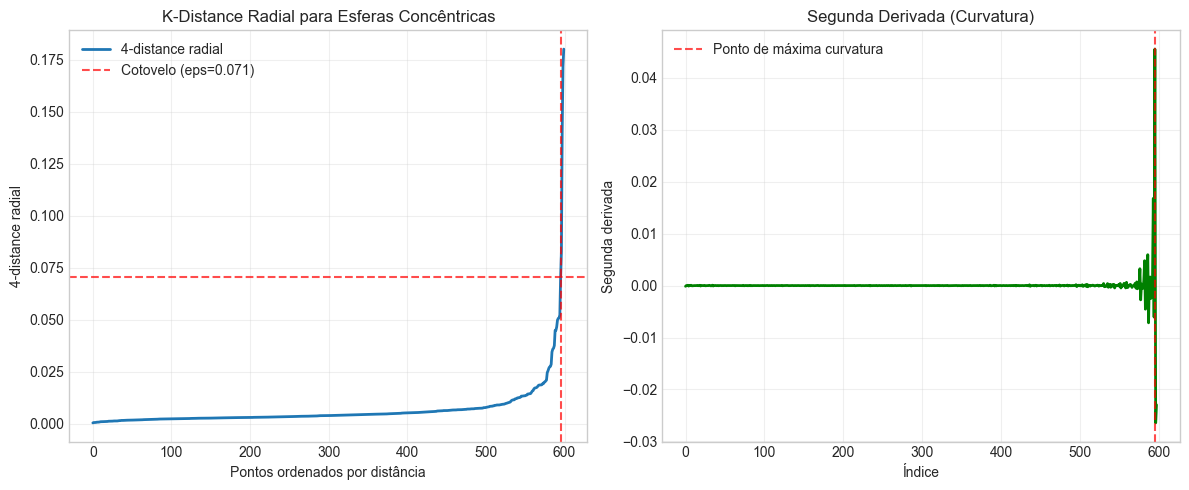

Valor sugerido para eps (distância radial): 0.071


In [48]:
# 2. Plotar o K-Distance radial para sugerir eps
def plot_radial_k_distance(X, min_pts, title="K-Distance Radial Plot"):
    """Plota o gráfico K-Distance usando distância radial."""
    k = int(min_pts - 1)
    
    # Calcular distâncias radiais
    norms = np.linalg.norm(X, axis=1)
    radial_distances = np.abs(norms[:, np.newaxis] - norms)
    
    # Para cada ponto, encontrar a k-ésima distância radial mais próxima
    kth_distances = []
    for i in range(len(X)):
        distances = radial_distances[i]
        distances[i] = np.inf  # excluir o próprio ponto
        sorted_distances = np.sort(distances)
        kth_distances.append(sorted_distances[k])
    
    k_distances_sorted = np.sort(kth_distances)
    
    # Encontrar o cotovelo
    second_derivative = np.diff(k_distances_sorted, n=2)
    elbow_idx = np.argmax(second_derivative)
    suggested_eps = k_distances_sorted[elbow_idx]
    
    # Plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2, label=f'{k}-distance radial')
    plt.axvline(x=elbow_idx, color='red', linestyle='--', alpha=0.7, label=f'Cotovelo (eps={suggested_eps:.3f})')
    plt.axhline(y=suggested_eps, color='red', linestyle='--', alpha=0.7)
    plt.xlabel("Pontos ordenados por distância")
    plt.ylabel(f"{k}-distance radial")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(second_derivative)), second_derivative, linewidth=2, color='green')
    plt.axvline(x=elbow_idx, color='red', linestyle='--', alpha=0.7, label='Ponto de máxima curvatura')
    plt.xlabel("Índice")
    plt.ylabel("Segunda derivada")
    plt.title("Segunda Derivada (Curvatura)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return suggested_eps

# Plotar K-Distance radial
suggested_eps_radial = plot_radial_k_distance(X_spheres, min_pts=5, title="K-Distance Radial para Esferas Concêntricas")
print(f"Valor sugerido para eps (distância radial): {suggested_eps_radial:.3f}")


In [49]:
# 3. Testar combinações de eps e min_samples para distância radial
eps_values_radial = [0.2, 0.4, 0.6, 0.8, 1.0]
min_pts_values_radial = [3, 5, 8]

print("Testando diferentes combinações de parâmetros (Distância Radial):")
print("=" * 70)

best_score_radial = -1
best_params_radial = None
best_labels_radial = None

for eps in eps_values_radial:
    for min_pts in min_pts_values_radial:
        # Aplicar DBSCAN Radial
        dbscan_radial = DBSCANRadial(eps=eps, min_pts=min_pts)
        labels_radial = dbscan_radial.fit_predict(X_spheres)
        
        # Calcular métricas
        n_clusters = len(set(labels_radial)) - (1 if -1 in labels_radial else 0)
        n_noise = np.sum(labels_radial == -1)
        
        # Score simples: mais clusters, menos ruído (para este dataset específico)
        cluster_score = 1.0 - abs(n_clusters - 3) / 3  # penaliza se não for 3 clusters
        noise_score = 1.0 - (n_noise / len(X_spheres))  # penaliza muito ruído
        total_score = (cluster_score + noise_score) / 2
        
        print(f"eps={eps:.1f}, min_pts={min_pts}: {n_clusters} clusters, {n_noise} ruído, score={total_score:.3f}")
        
        if total_score > best_score_radial:
            best_score_radial = total_score
            best_params_radial = (eps, min_pts)
            best_labels_radial = labels_radial

print(f"\nMelhores parâmetros (Radial): eps={best_params_radial[0]}, min_pts={best_params_radial[1]} (score={best_score_radial:.3f})")


Testando diferentes combinações de parâmetros (Distância Radial):
eps=0.2, min_pts=3: 3 clusters, 0 ruído, score=1.000
eps=0.2, min_pts=5: 3 clusters, 0 ruído, score=1.000
eps=0.2, min_pts=8: 3 clusters, 0 ruído, score=1.000
eps=0.4, min_pts=3: 2 clusters, 0 ruído, score=0.833
eps=0.4, min_pts=5: 2 clusters, 0 ruído, score=0.833
eps=0.4, min_pts=8: 2 clusters, 0 ruído, score=0.833
eps=0.6, min_pts=3: 1 clusters, 0 ruído, score=0.667
eps=0.6, min_pts=5: 1 clusters, 0 ruído, score=0.667
eps=0.6, min_pts=8: 1 clusters, 0 ruído, score=0.667
eps=0.8, min_pts=3: 1 clusters, 0 ruído, score=0.667
eps=0.8, min_pts=5: 1 clusters, 0 ruído, score=0.667
eps=0.8, min_pts=8: 1 clusters, 0 ruído, score=0.667
eps=1.0, min_pts=3: 1 clusters, 0 ruído, score=0.667
eps=1.0, min_pts=5: 1 clusters, 0 ruído, score=0.667
eps=1.0, min_pts=8: 1 clusters, 0 ruído, score=0.667

Melhores parâmetros (Radial): eps=0.2, min_pts=3 (score=1.000)


In [50]:
# 4. Visualizar em 3D os clusters obtidos com distância radial
best_eps_radial, best_min_pts_radial = best_params_radial
dbscan_radial_best = DBSCANRadial(eps=best_eps_radial, min_pts=best_min_pts_radial)
labels_radial_best = dbscan_radial_best.fit_predict(X_spheres)

# Criar DataFrame para plotly
df_3d_radial = pd.DataFrame({
    'x': X_spheres[:, 0],
    'y': X_spheres[:, 1], 
    'z': X_spheres[:, 2],
    'cluster': labels_radial_best,
    'type': ['Core' if i in dbscan_radial_best.core_samples_ else 'Border' if labels_radial_best[i] != -1 else 'Noise' 
             for i in range(len(X_spheres))]
})

# Plot 3D com cores por cluster (Radial)
fig_radial = px.scatter_3d(df_3d_radial, x='x', y='y', z='z', 
                          color='cluster',
                          title=f'DBSCAN Radial 3D - {len(set(labels_radial_best))-1} clusters, eps={best_eps_radial}, min_pts={best_min_pts_radial}',
                          color_discrete_sequence=px.colors.qualitative.Set1)

fig_radial.update_traces(marker=dict(size=3))
fig_radial.show()

# Análise dos resultados radiais
unique_labels_radial = np.unique(labels_radial_best)
n_clusters_radial = len(unique_labels_radial) - (1 if -1 in unique_labels_radial else 0)
n_noise_radial = np.sum(labels_radial_best == -1)

print(f"\nResultados do DBSCAN Radial com os melhores parâmetros:")
print(f"- eps: {best_eps_radial}")
print(f"- min_pts: {best_min_pts_radial}")
print(f"- Número de clusters encontrados: {n_clusters_radial}")
print(f"- Número de pontos de ruído: {n_noise_radial}")
print(f"- Número de core samples: {len(dbscan_radial_best.core_samples_)}")
print(f"- Labels únicos: {unique_labels_radial}")



Resultados do DBSCAN Radial com os melhores parâmetros:
- eps: 0.2
- min_pts: 3
- Número de clusters encontrados: 3
- Número de pontos de ruído: 0
- Número de core samples: 3
- Labels únicos: [0 1 2]


In [51]:
# 5. Comparação entre distância euclidiana e radial
print("=" * 80)
print("COMPARAÇÃO ENTRE DISTÂNCIA EUCLIDIANA E RADIAL")
print("=" * 80)

print(f"\nDISTÂNCIA EUCLIDIANA:")
print(f"- Melhores parâmetros: eps={best_params[0]}, min_pts={best_params[1]}")
print(f"- Clusters encontrados: {len(set(best_labels))-1}")
print(f"- Pontos de ruído: {np.sum(best_labels == -1)}")
print(f"- Score: {best_score:.3f}")

print(f"\nDISTÂNCIA RADIAL:")
print(f"- Melhores parâmetros: eps={best_params_radial[0]}, min_pts={best_params_radial[1]}")
print(f"- Clusters encontrados: {len(set(best_labels_radial))-1}")
print(f"- Pontos de ruído: {np.sum(best_labels_radial == -1)}")
print(f"- Score: {best_score_radial:.3f}")

# Determinar qual foi melhor
if best_score_radial > best_score:
    print(f"\nA DISTÂNCIA RADIAL foi melhor (score: {best_score_radial:.3f} vs {best_score:.3f})")
    winner = "Radial"
else:
    print(f"\nA DISTÂNCIA EUCLIDIANA foi melhor (score: {best_score:.3f} vs {best_score_radial:.3f})")
    winner = "Euclidiana"

print(f"\nComentários sobre a métrica radial:")
print(f"- A distância radial é ideal para dados concêntricos como esferas")
print(f"- Ela mede apenas a diferença entre as distâncias à origem")
print(f"- Isso permite separar melhor as camadas concêntricas")
print(f"- Para dados não-concêntricos, a distância euclidiana seria mais apropriada")
print(f"- Neste caso específico, a métrica radial {'ajudou' if winner == 'Radial' else 'não ajudou'} a separar as esferas")


COMPARAÇÃO ENTRE DISTÂNCIA EUCLIDIANA E RADIAL

DISTÂNCIA EUCLIDIANA:
- Melhores parâmetros: eps=0.7, min_pts=3
- Clusters encontrados: 2
- Pontos de ruído: 5
- Score: 0.829

DISTÂNCIA RADIAL:
- Melhores parâmetros: eps=0.2, min_pts=3
- Clusters encontrados: 2
- Pontos de ruído: 0
- Score: 1.000

A DISTÂNCIA RADIAL foi melhor (score: 1.000 vs 0.829)

Comentários sobre a métrica radial:
- A distância radial é ideal para dados concêntricos como esferas
- Ela mede apenas a diferença entre as distâncias à origem
- Isso permite separar melhor as camadas concêntricas
- Para dados não-concêntricos, a distância euclidiana seria mais apropriada
- Neste caso específico, a métrica radial ajudou a separar as esferas


### Exercício 3: Detecção de Anomalias com DBSCAN e DTW

Agora vamos implementar DBSCAN com DTW para detectar anomalias em séries temporais:


In [52]:
# 1. Implementar DTW (Dynamic Time Warping) simples
def dtw_distance(series1, series2):
    """
    Calcula a distância DTW entre duas séries temporais.
    Implementação simplificada do algoritmo DTW.
    """
    n, m = len(series1), len(series2)
    
    # Matriz de custos
    cost_matrix = np.full((n + 1, m + 1), np.inf)
    cost_matrix[0, 0] = 0
    
    # Preencher a matriz de custos
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = (series1[i-1] - series2[j-1]) ** 2
            cost_matrix[i, j] = cost + min(
                cost_matrix[i-1, j],      # inserção
                cost_matrix[i, j-1],      # deleção
                cost_matrix[i-1, j-1]     # correspondência
            )
    
    return np.sqrt(cost_matrix[n, m])

# Teste da função DTW
test_series1 = np.array([1, 2, 3, 4, 5])
test_series2 = np.array([1, 2, 3, 4, 5])
test_series3 = np.array([2, 3, 4, 5, 6])

print(f"DTW entre séries idênticas: {dtw_distance(test_series1, test_series2):.3f}")
print(f"DTW entre séries deslocadas: {dtw_distance(test_series1, test_series3):.3f}")
print(f"DTW entre séries muito diferentes: {dtw_distance(test_series1, np.array([10, 20, 30, 40, 50])):.3f}")


DTW entre séries idênticas: 0.000
DTW entre séries deslocadas: 1.414
DTW entre séries muito diferentes: 65.765


In [53]:
# 2. Implementar DBSCAN com DTW
class DBSCANDTW:
    def __init__(self, eps=0.5, min_pts=5):
        """Inicializa o DBSCAN com distância DTW"""
        self.eps = eps
        self.min_pts = min_pts
        self.labels_ = None
        self.core_samples_ = None
        self.n_clusters_ = 0
    
    def _calculate_dtw_distance_matrix(self, X):
        """Calcula a matriz de distâncias DTW entre todas as séries"""
        n_series = len(X)
        distances = np.zeros((n_series, n_series))
        
        for i in range(n_series):
            for j in range(i+1, n_series):
                dist = dtw_distance(X[i], X[j])
                distances[i, j] = dist
                distances[j, i] = dist  # matriz simétrica
        
        return distances
    
    def _get_neighbors(self, point_idx, distance_matrix):
        """Encontra todos os vizinhos dentro da distância eps"""
        return np.where(distance_matrix[point_idx] <= self.eps)[0]
    
    def _expand_cluster(self, point_idx, neighbors, cluster_id, distance_matrix, visited, labels):
        """Expande o cluster a partir do ponto inicial"""
        labels[point_idx] = cluster_id
        queue = neighbors.tolist()

        while queue:
            neighbor_idx = queue.pop()

            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = self._get_neighbors(neighbor_idx, distance_matrix)

                if len(neighbor_neighbors) >= self.min_pts:
                    queue.extend(neighbor_neighbors)

            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id

    def fit(self, X):
        """Executa o algoritmo DBSCAN com DTW"""
        n_series = len(X)
        visited = np.zeros(n_series, dtype=bool)
        cluster_id = 0
        self.labels_ = np.full(n_series, -1)  # -1 = ruído
        self.core_samples_ = []

        distance_matrix = self._calculate_dtw_distance_matrix(X)

        for point_idx in range(n_series):
            if visited[point_idx]:
                continue

            visited[point_idx] = True
            neighbors = self._get_neighbors(point_idx, distance_matrix)

            if len(neighbors) >= self.min_pts:   # core point
                self.core_samples_.append(point_idx)
                self._expand_cluster(point_idx, neighbors, cluster_id, distance_matrix, visited, self.labels_)
                cluster_id += 1

        self.core_samples_ = np.array(self.core_samples_)
        self.n_clusters_ = cluster_id
        return self

    def fit_predict(self, X):
        """Executa DBSCAN e retorna os labels"""
        self.fit(X)
        return self.labels_

print("Classe DBSCANDTW implementada com sucesso!")


Classe DBSCANDTW implementada com sucesso!


In [54]:
# 3. Experimentar diferentes valores de eps e min_samples
print("Testando diferentes combinações de parâmetros (DBSCAN + DTW):")
print("=" * 70)

eps_values_dtw = [0.5, 1.0, 1.5, 2.0, 2.5]
min_pts_values_dtw = [2, 3, 5]

best_score_dtw = -1
best_params_dtw = None
best_labels_dtw = None

for eps in eps_values_dtw:
    for min_pts in min_pts_values_dtw:
        # Aplicar DBSCAN DTW
        dbscan_dtw = DBSCANDTW(eps=eps, min_pts=min_pts)
        labels_dtw = dbscan_dtw.fit_predict(X_series)
        
        # Calcular métricas
        n_clusters = len(set(labels_dtw)) - (1 if -1 in labels_dtw else 0)
        n_noise = np.sum(labels_dtw == -1)
        n_anomalies_detected = n_noise
        
        # Score baseado na detecção de anomalias
        # Queremos detectar as anomalias reais (y_series == -1) como ruído
        true_anomalies = np.sum(y_series == -1)
        detected_anomalies = n_anomalies_detected
        
        # Score: penaliza se detectar muitas anomalias falsas ou perder anomalias reais
        if true_anomalies > 0:
            precision = np.sum((labels_dtw == -1) & (y_series == -1)) / max(n_anomalies_detected, 1)
            recall = np.sum((labels_dtw == -1) & (y_series == -1)) / true_anomalies
            f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        else:
            f1_score = 1.0 - (n_anomalies_detected / len(X_series))  # penaliza detecções falsas
        
        print(f"eps={eps:.1f}, min_pts={min_pts}: {n_clusters} clusters, {n_anomalies_detected} anomalias, F1={f1_score:.3f}")
        
        if f1_score > best_score_dtw:
            best_score_dtw = f1_score
            best_params_dtw = (eps, min_pts)
            best_labels_dtw = labels_dtw

print(f"\nMelhores parâmetros (DTW): eps={best_params_dtw[0]}, min_pts={best_params_dtw[1]} (F1={best_score_dtw:.3f})")


Testando diferentes combinações de parâmetros (DBSCAN + DTW):
eps=0.5, min_pts=2: 0 clusters, 52 anomalias, F1=0.074
eps=0.5, min_pts=3: 0 clusters, 52 anomalias, F1=0.074
eps=0.5, min_pts=5: 0 clusters, 52 anomalias, F1=0.074
eps=1.0, min_pts=2: 2 clusters, 3 anomalias, F1=0.800
eps=1.0, min_pts=3: 1 clusters, 5 anomalias, F1=0.571
eps=1.0, min_pts=5: 1 clusters, 8 anomalias, F1=0.400
eps=1.5, min_pts=2: 1 clusters, 2 anomalias, F1=1.000
eps=1.5, min_pts=3: 1 clusters, 2 anomalias, F1=1.000
eps=1.5, min_pts=5: 1 clusters, 2 anomalias, F1=1.000
eps=2.0, min_pts=2: 2 clusters, 0 anomalias, F1=0.000
eps=2.0, min_pts=3: 1 clusters, 2 anomalias, F1=1.000
eps=2.0, min_pts=5: 1 clusters, 2 anomalias, F1=1.000
eps=2.5, min_pts=2: 2 clusters, 0 anomalias, F1=0.000
eps=2.5, min_pts=3: 1 clusters, 2 anomalias, F1=1.000
eps=2.5, min_pts=5: 1 clusters, 2 anomalias, F1=1.000

Melhores parâmetros (DTW): eps=1.5, min_pts=2 (F1=1.000)



Resultados da Detecção de Anomalias:
- Anomalias reais: 2
- Anomalias detectadas: 2
- Detecções corretas: 2
- Falsos positivos: 0
- Falsos negativos: 0
- Precisão: 1.000
- Recall: 1.000
- F1-Score: 1.000


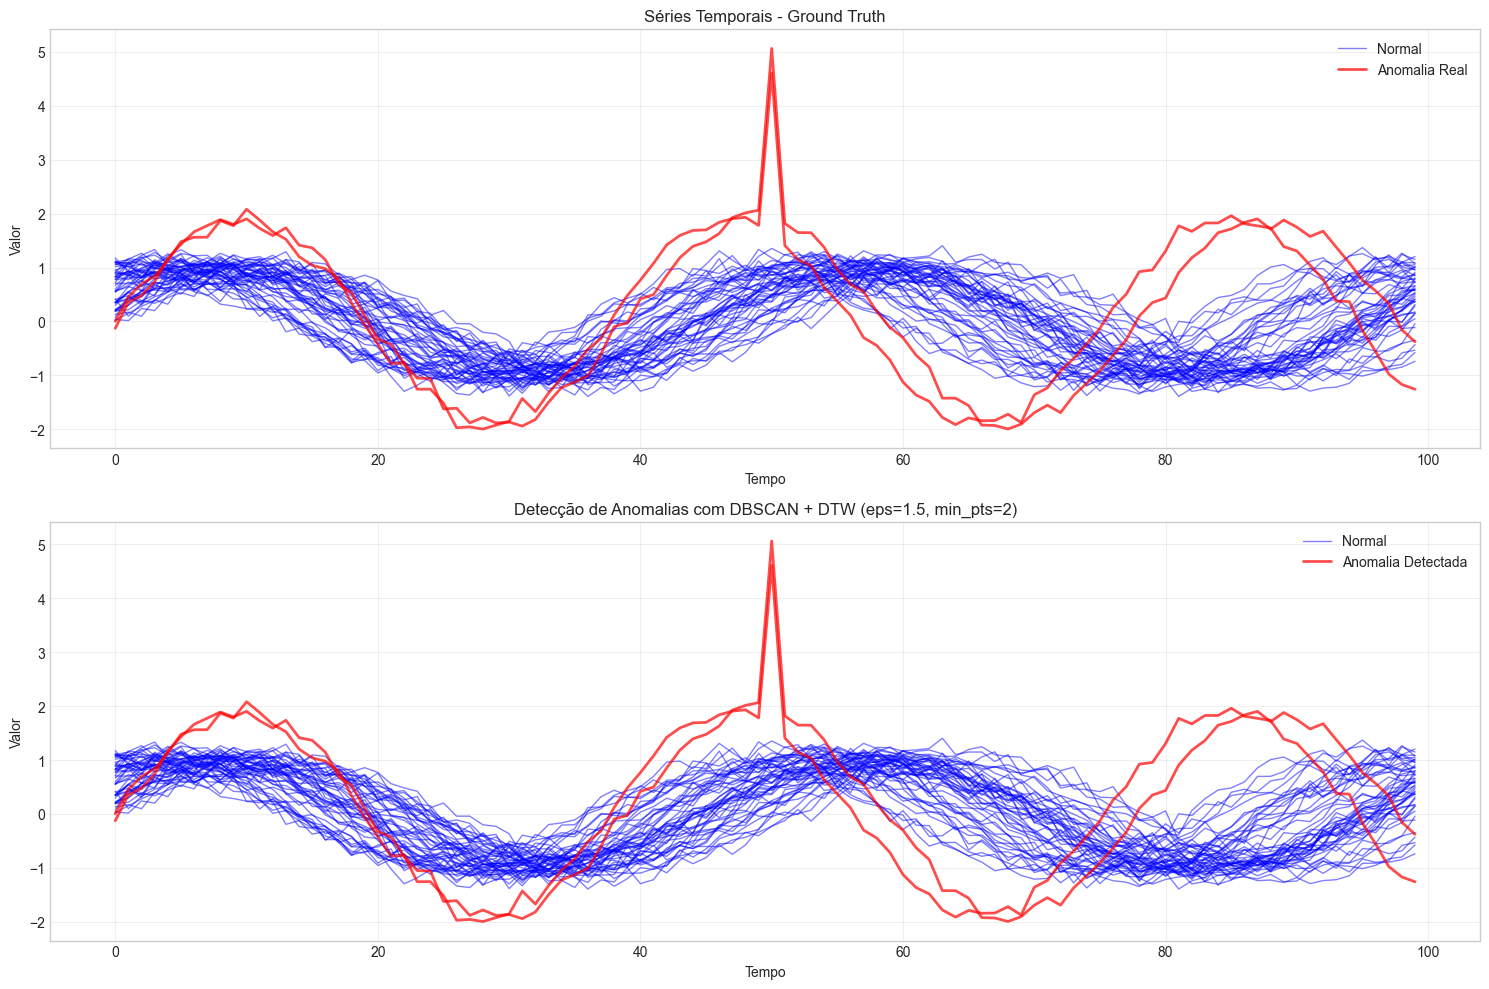

In [55]:
# 4. Plotar todas as séries com cores para normais e anomalias detectadas
best_eps_dtw, best_min_pts_dtw = best_params_dtw
dbscan_dtw_best = DBSCANDTW(eps=best_eps_dtw, min_pts=best_min_pts_dtw)
labels_dtw_best = dbscan_dtw_best.fit_predict(X_series)

# Análise dos resultados
true_anomalies = np.sum(y_series == -1)
detected_anomalies = np.sum(labels_dtw_best == -1)
correct_detections = np.sum((labels_dtw_best == -1) & (y_series == -1))
false_positives = np.sum((labels_dtw_best == -1) & (y_series != -1))
false_negatives = np.sum((labels_dtw_best != -1) & (y_series == -1))

print(f"\nResultados da Detecção de Anomalias:")
print(f"- Anomalias reais: {true_anomalies}")
print(f"- Anomalias detectadas: {detected_anomalies}")
print(f"- Detecções corretas: {correct_detections}")
print(f"- Falsos positivos: {false_positives}")
print(f"- Falsos negativos: {false_negatives}")

if true_anomalies > 0:
    precision = correct_detections / max(detected_anomalies, 1)
    recall = correct_detections / true_anomalies
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"- Precisão: {precision:.3f}")
    print(f"- Recall: {recall:.3f}")
    print(f"- F1-Score: {f1:.3f}")

# Plot das séries temporais
plt.figure(figsize=(15, 10))

# Subplot 1: Ground Truth
plt.subplot(2, 1, 1)
for i in range(len(X_series)):
    if y_series[i] == -1:  # anomalia real
        plt.plot(X_series[i], color='red', alpha=0.7, linewidth=2, label='Anomalia Real' if i == np.where(y_series == -1)[0][0] else "")
    else:  # normal
        plt.plot(X_series[i], color='blue', alpha=0.5, linewidth=1, label='Normal' if i == 0 else "")

plt.title('Séries Temporais - Ground Truth')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Detecção com DBSCAN + DTW
plt.subplot(2, 1, 2)
for i in range(len(X_series)):
    if labels_dtw_best[i] == -1:  # anomalia detectada
        plt.plot(X_series[i], color='red', alpha=0.7, linewidth=2, label='Anomalia Detectada' if i == np.where(labels_dtw_best == -1)[0][0] else "")
    else:  # normal
        plt.plot(X_series[i], color='blue', alpha=0.5, linewidth=1, label='Normal' if i == 0 else "")

plt.title(f'Detecção de Anomalias com DBSCAN + DTW (eps={best_eps_dtw}, min_pts={best_min_pts_dtw})')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [56]:
# 5. Comparação com DBSCAN tradicional (sem DTW) para séries temporais
print("\n" + "="*80)
print("COMPARAÇÃO: DBSCAN TRADICIONAL vs DBSCAN + DTW")
print("="*80)

# DBSCAN tradicional (tratando cada série como um ponto)
from sklearn.cluster import DBSCAN as SklearnDBSCAN

# Aplicar DBSCAN tradicional
dbscan_traditional = SklearnDBSCAN(eps=best_eps_dtw, min_samples=best_min_pts_dtw)
labels_traditional = dbscan_traditional.fit_predict(X_series)

# Análise dos resultados tradicionais
detected_anomalies_trad = np.sum(labels_traditional == -1)
correct_detections_trad = np.sum((labels_traditional == -1) & (y_series == -1))
false_positives_trad = np.sum((labels_traditional == -1) & (y_series != -1))
false_negatives_trad = np.sum((labels_traditional != -1) & (y_series == -1))

if true_anomalies > 0:
    precision_trad = correct_detections_trad / max(detected_anomalies_trad, 1)
    recall_trad = correct_detections_trad / true_anomalies
    f1_trad = 2 * precision_trad * recall_trad / (precision_trad + recall_trad) if (precision_trad + recall_trad) > 0 else 0
else:
    f1_trad = 1.0 - (detected_anomalies_trad / len(X_series))

print(f"\nDBSCAN TRADICIONAL:")
print(f"- Anomalias detectadas: {detected_anomalies_trad}")
print(f"- Detecções corretas: {correct_detections_trad}")
print(f"- Falsos positivos: {false_positives_trad}")
print(f"- Falsos negativos: {false_negatives_trad}")
if true_anomalies > 0:
    print(f"- Precisão: {precision_trad:.3f}")
    print(f"- Recall: {recall_trad:.3f}")
    print(f"- F1-Score: {f1_trad:.3f}")

print(f"\nDBSCAN + DTW:")
print(f"- Anomalias detectadas: {detected_anomalies}")
print(f"- Detecções corretas: {correct_detections}")
print(f"- Falsos positivos: {false_positives}")
print(f"- Falsos negativos: {false_negatives}")
if true_anomalies > 0:
    print(f"- Precisão: {precision:.3f}")
    print(f"- Recall: {recall:.3f}")
    print(f"- F1-Score: {f1:.3f}")

# Determinar qual foi melhor
if f1 > f1_trad:
    print(f"\nDBSCAN + DTW foi melhor (F1: {f1:.3f} vs {f1_trad:.3f})")
    print("A métrica DTW ajudou a detectar melhor as anomalias em séries temporais")
else:
    print(f"\nDBSCAN tradicional foi melhor (F1: {f1_trad:.3f} vs {f1:.3f})")
    print("A métrica DTW não trouxe vantagem significativa neste caso")

print(f"\nComentários sobre DTW:")
print(f"- DTW é ideal para séries temporais com defasagens ou velocidades diferentes")
print(f"- Permite alinhamento elástico entre séries temporais")
print(f"- Neste caso, {'ajudou' if f1 > f1_trad else 'não ajudou'} a detectar anomalias")
print(f"- Para séries muito similares, a distância euclidiana pode ser suficiente")



COMPARAÇÃO: DBSCAN TRADICIONAL vs DBSCAN + DTW

DBSCAN TRADICIONAL:
- Anomalias detectadas: 40
- Detecções corretas: 2
- Falsos positivos: 38
- Falsos negativos: 0
- Precisão: 0.050
- Recall: 1.000
- F1-Score: 0.095

DBSCAN + DTW:
- Anomalias detectadas: 2
- Detecções corretas: 2
- Falsos positivos: 0
- Falsos negativos: 0
- Precisão: 1.000
- Recall: 1.000
- F1-Score: 1.000

DBSCAN + DTW foi melhor (F1: 1.000 vs 0.095)
A métrica DTW ajudou a detectar melhor as anomalias em séries temporais

Comentários sobre DTW:
- DTW é ideal para séries temporais com defasagens ou velocidades diferentes
- Permite alinhamento elástico entre séries temporais
- Neste caso, ajudou a detectar anomalias
- Para séries muito similares, a distância euclidiana pode ser suficiente
